In [1]:
import numpy as np
import pandas as pd
import nltk
import seaborn as sn
import matplotlib.pyplot as plt
import language_tool_python
import scipy.stats as stats

tool = language_tool_python.LanguageTool('en-US')
is_bad_rule = lambda rule: rule.message == 'Possible spelling mistake found.' and len(rule.replacements) and rule.replacements[0][0].isupper()

## Data importation

In [2]:
df_fixed = pd.read_csv('data/fixed_text_typing_dataset.csv', sep=';')
df_freq = pd.read_csv('data/frequency_dataset.csv', sep=';')
df_user = pd.read_csv('data/participants_information.csv', sep=';')

df_freq = df_freq.rename(columns={'User ID':'userId'})

## Sentences reconstruction and feature extraction

In [3]:
# reconstruct users' sentences from the keycode in df_fixed

sentence = ''
uppercase = False
uppercase_tmp = False
i_start = 0
i_end = 0
text_fixed = pd.DataFrame(columns=['sentence', 'idx_start', 'idx_end'])

df_fixed.keyCode = df_fixed.keyCode.astype(str)

for i in range(len(df_fixed)):
    if i > 0 and (df_fixed.userId[i] != df_fixed.userId[i-1] or df_fixed.emotionIndex[i] != df_fixed.emotionIndex[i-1]): #df_fixed._id[i][:-2] != df_fixed._id[i-1][:-2]:
        i_end = i-1
        if len(text_fixed) == 62:
            ids_start = [i for i in range(len(sentence)) if sentence[i:i+4] == 'once']
            text_fixed = text_fixed.append(pd.DataFrame([[sentence, i_start, i_start+ids_start[1]-1]], columns=['sentence', 'idx_start', 'idx_end']), ignore_index = True)
            text_fixed = text_fixed.append(pd.DataFrame([[sentence, i_start+ids_start[1], i_start+ids_start[2]-1]], columns=['sentence', 'idx_start', 'idx_end']), ignore_index = True)
            text_fixed = text_fixed.append(pd.DataFrame([[sentence, i_start+ids_start[2], i_end]], columns=['sentence', 'idx_start', 'idx_end']), ignore_index = True)
        elif len(text_fixed) == 134 or len(text_fixed) == 190:
            ids_start = [i for i in range(len(sentence)) if sentence[i:i+4] == 'Once']
            text_fixed = text_fixed.append(pd.DataFrame([[sentence, i_start, i_start+ids_start[1]-1]], columns=['sentence', 'idx_start', 'idx_end']), ignore_index = True)
            text_fixed = text_fixed.append(pd.DataFrame([[sentence, i_start+ids_start[1], i_end]], columns=['sentence', 'idx_start', 'idx_end']), ignore_index = True)
        else:
            if sentence[0].islower() and sentence[1].isupper():
                sentence = sentence.swapcase()
            text_fixed = text_fixed.append(pd.DataFrame([[sentence, i_start, i_end]], columns=['sentence', 'idx_start', 'idx_end']), ignore_index = True)
        i_start = i
        sentence = ''
        uppercase = False
        uppercase_tmp = False
    if df_fixed.keyCode[i] == '\\b':    # delete key
        sentence = sentence[:max(0,len(sentence)-1)]
        uppercase_tmp = False
        continue
    if df_fixed.keyCode[i] == '\\u0014':    # caps lock key
        uppercase = not uppercase
        continue
    if df_fixed.keyCode[i] == '\\u0010' and not uppercase:     # shift key
        uppercase_tmp = True
        continue
    if df_fixed.keyCode[i] == '¼':     # comma key
        sentence += ','
        uppercase_tmp = False
        continue
    if df_fixed.keyCode[i] == 'ß':     # exclamation mark key
        sentence += '!'
        uppercase_tmp = False
        continue
    if df_fixed.keyCode[i] == '¾':     # dot key
        sentence += '.'
        uppercase_tmp = False
        continue
    if df_fixed.keyCode[i] == '4    ':     # apostrophe key
        sentence += "'"
        uppercase_tmp = False
        continue
    if df_fixed.keyCode[i] == '6    ':     # dash key
        sentence += "-"
        uppercase_tmp = False
        continue
    if df_fixed.keyCode[i] == '¿':     # colon key
        sentence += ":"
        uppercase_tmp = False
        continue
    if uppercase:
        sentence += df_fixed.keyCode[i].upper()
        continue
    if uppercase_tmp:
        sentence += df_fixed.keyCode[i].upper()
        uppercase_tmp = False
        continue
    sentence += df_fixed.keyCode[i]    

text_fixed = text_fixed.append(pd.DataFrame([[sentence, i_start, i]], columns=['sentence', 'idx_start', 'idx_end']), ignore_index = True)

### Fixed text

In [4]:
# fixed text that users have been asked to write

gold_fixed = {
    'N': 'Once there was a cat and a mouse. Usually, cats eat mice, and mice run away from cats. But this cat and this mouse liked each other very much. They liked each other so much that they lived together.',
    'H': 'We can not help falling in love with cute and funny babies. Their beautiful and joyful laughter makes us happy.',
    'C': 'Beautiful nature and calm music are always relaxing. The soft sounds are so pleasant to listen to. Watching the superb nature calms our body and soul.',
    'S': 'The boy yells at his father to wake him up. But the father is dead. The poor boy is very sad. He realized that his father is gone forever.',
    'A': 'Jake has a horrible temper, especially when he drinks alcohol. He gets andgry and agressive when he is drunk. He savagely  beats and violeates his wife.'
    }

In [5]:
# functions to extract features from the df_fixed table
df_fixed = df_fixed.drop(['D1U3','D1D3'], axis=1)
df_fixed.head()

,userId,emotionIndex,index,keyCode,keyDown,keyUp,D1U1,D1U2,D1D2,U1D2,U1U2,answer
0,100,N,3448,o,1.580000e+12,1.580000e+12,90.0,2556.0,2479.0,2389.0,2466.0,NaN
1,100,N,3449,n,1.580000e+12,1.580000e+12,77.0,258.0,131.0,54.0,181.0,NaN
2,100,N,3450,c,1.580000e+12,1.580000e+12,127.0,613.0,519.0,392.0,486.0,NaN
3,100,N,3451,e,1.580000e+12,1.580000e+12,94.0,276.0,200.0,106.0,182.0,NaN
4,100,N,3452,,1.580000e+12,1.580000e+12,76.0,2104.0,2032.0,1956.0,2028.0,NaN


In [6]:
def extract_editDistance_fixed(gold_fixed, emotion, sentence):
    return nltk.edit_distance(sentence, gold_fixed[emotion])

def extract_nbKeystroke(val, start, end):
    return val[end] - val[start] + 1

def extract_mean(val, start, end):
    return np.mean(val[start:end+1])

def extract_std(val, start, end):
    return np.std(val[start:end+1])

def extract_answer(val, start, end):
    for i in range(start, end+1):
        if val[i] != np.nan:
            return val[i]
    return np.nan

In [7]:
key_features = ['D1U1','D1U2','D1D2','U1D2','U1U2']

text_fixed['userId'] = df_fixed.userId[text_fixed.idx_start].values
text_fixed['emotionIndex'] = df_fixed.emotionIndex[text_fixed.idx_start].values
text_fixed = text_fixed.reindex(columns=['idx_start','idx_end','userId','emotionIndex','sentence'])
text_fixed['editDistance'] = text_fixed.apply(lambda x: extract_editDistance_fixed(gold_fixed, x['emotionIndex'], x['sentence']), axis=1)
text_fixed['nbKeystroke'] = text_fixed.apply(lambda x: extract_nbKeystroke(df_fixed.index, x['idx_start'], x['idx_end']), axis=1)
text_fixed['answer'] = text_fixed.apply(lambda x: extract_answer(df_fixed.answer, x['idx_start'], x['idx_end']), axis=1)

for feat in key_features:
    df_fixed[feat] = df_fixed[feat].apply(lambda x: np.nan if np.abs(x) > 1570000000000 else x)
    text_fixed[feat+'_mean'] = text_fixed.apply(lambda x: extract_mean(df_fixed[feat], x['idx_start'], x['idx_end']), axis=1)
    text_fixed[feat+'_std'] = text_fixed.apply(lambda x: extract_std(df_fixed[feat], x['idx_start'], x['idx_end']), axis=1)


text_fixed.head()

,idx_start,idx_end,userId,emotionIndex,sentence,editDistance,nbKeystroke,answer,D1U1_mean,D1U1_std,D1U2_mean,D1U2_std,D1D2_mean,D1D2_std,U1D2_mean,U1D2_std,U1U2_mean,U1U2_std
0,0,282,100,N,"once there was a cat and a mouse. usually , ca...",26,283,NaN,96.074380,31.715592,884.215768,1157.264475,683.060284,1101.553201,694.609959,1157.337134,677.178571,1108.432937
1,283,422,100,H,We can not help falling in love with cute and ...,2,140,R,99.071429,22.182246,813.769784,701.131104,714.784173,699.459223,615.776978,696.222821,714.762590,697.865776
2,423,656,113,N,Once there was a cat and a mouse\u0010. Usaual...,23,234,NaN,88.440171,35.663291,449.802575,381.758170,361.309013,379.970339,272.832618,380.091995,361.326180,381.705475
3,657,840,113,C,Beautiful nature and calm music are always rel...,6,184,R,92.587571,51.886713,526.255682,613.476557,426.710383,601.426508,347.096591,614.503538,421.160221,614.552941
4,841,978,113,H,We can not help falling in love with cute and ...,2,138,R,92.086957,54.058138,443.934307,332.686657,352.138686,325.048838,260.189781,325.204406,351.985401,332.486627


[]

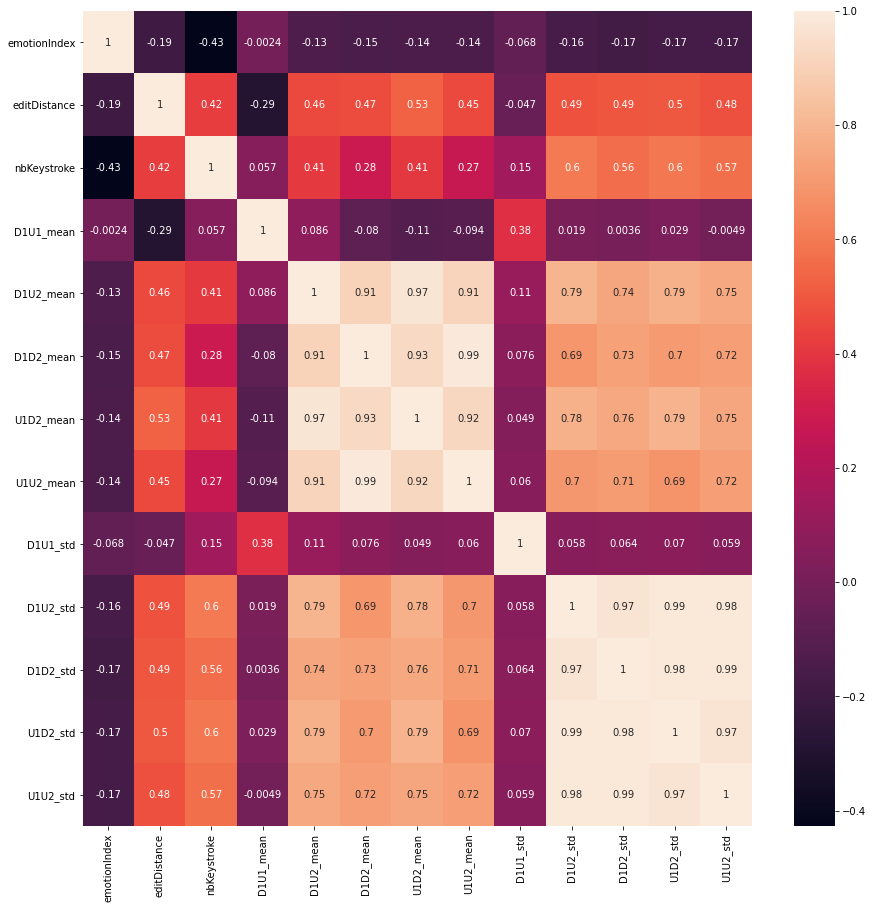

In [8]:
## correlation matrix

# Numeric columns of the dataset
text_fixed.emotionIndex = text_fixed.emotionIndex.map({'N':0,'H':1,'C':2,'S':3,'A':4})
numeric_col = ['emotionIndex','editDistance','nbKeystroke'] + [col for col in text_fixed.columns if '_mean' in col] + [col for col in text_fixed.columns if '_std' in col]

# Correlation Matrix formation
corr_matrix = text_fixed.loc[:, numeric_col].corr()
text_fixed.emotionIndex = text_fixed.emotionIndex.map({0:'N',1:'H',2:'C',3:'S',4:'A'})
 
#Using heatmap to visualize the correlation matrix
plt.figure(figsize = (15,15))
sn.heatmap(corr_matrix, annot=True)
plt.plot()

## Join tables: text_fixed with df_freq_fixed

In [9]:
# filter fixed-text experiments in df_freq
df_freq_fixed = df_freq[df_freq.textIndex == 'FI'].reset_index(drop=True)

In [10]:
# correction of expections to align df_freq_fixed and text_fixed tables
text_fixed.loc[44,'userId'] = 94
tmp = text_fixed.loc[30]
text_fixed.loc[30] = text_fixed.loc[31]
text_fixed.loc[31] = tmp

In [11]:
# alignment of df_freq_fixed and text_fixed tables
text_fixed['text_index'] = -1
df_freq_fixed['text_index'] = -1
index = 0

i = 0
j = 0
while i<len(df_freq_fixed) and j<len(text_fixed):
    if df_freq_fixed.userId[i] == text_fixed.userId[j] and df_freq_fixed.emotionIndex[i] == text_fixed.emotionIndex[j]:
        df_freq_fixed.loc[i,'text_index'] = index
        text_fixed.loc[j,'text_index'] = index
        index += 1
        i += 1
        j += 1
    elif j != len(text_fixed)-1 and df_freq_fixed.userId[i] == text_fixed.userId[j+1] and df_freq_fixed.emotionIndex[i] == text_fixed.emotionIndex[j+1]:
        df_freq_fixed.loc[i,'text_index'] = index
        text_fixed.loc[j+1,'text_index'] = index
        index += 1
        i += 1
        j += 2
    elif i != len(df_freq_fixed)-1 and df_freq_fixed.userId[i+1] == text_fixed.userId[j] and df_freq_fixed.emotionIndex[i+1] == text_fixed.emotionIndex[j]:
        df_freq_fixed.loc[i+1,'text_index'] = index
        text_fixed.loc[j,'text_index'] = index
        index += 1
        i += 2
        j += 1
    else:
        i += 1
        j += 1

In [12]:
# correction of expections to align df_freq_fixed and df_user tables
tmp = df_user.loc[92]
df_user.loc[92] = df_user.loc[91]
df_user.loc[91] = tmp

In [13]:
## alignment of df_freq_index and df_user tables
df_freq_fixed['user_index'] = -1
index = 0

j = 0
for i in range(len(df_freq_fixed)):
    if i in [39,59,71,145,156,159,179,235]: 
        j += 1
    if j < len(df_user) and df_freq_fixed.userId[i] == df_user.userId[j]:
        df_freq_fixed.loc[i,'user_index'] = j
        i += 1
    else:
        if j < len(df_user)-1 and df_freq_fixed.userId[i] == df_user.userId[j+1]:
            df_freq_fixed.loc[i,'user_index'] = j+1
            i += 1
            j += 1
        else:
            for k in range(1,6):
                if df_freq_fixed.userId[i] == df_freq_fixed.userId[i-k]:
                    df_freq_fixed.loc[i,'user_index'] = df_freq_fixed.loc[i-k,'user_index']
                    break

In [14]:
# merge all tables
df_fixed_all = df_freq_fixed.join(text_fixed, on='text_index', how='left', rsuffix='_right')
df_fixed_all = df_fixed_all.drop(['userId_right', 'emotionIndex_right', 'text_index_right'], axis=1)
df_fixed_all = df_fixed_all.join(df_user.reset_index().rename(columns={'index':'user_index'}), on='user_index', how='left', rsuffix='_right')
df_fixed_all = df_fixed_all.drop(['user_index_right','userId_right'], axis=1)
df_fixed_all.head()

,userId,textIndex,emotionIndex,delFreq,leftFreq,TotTime,text_index,user_index,idx_start,idx_end,...,U1U2_mean,U1U2_std,typeWith,typistType,pcTimeAverage,ageRange,gender,status,degree,country
0,100,FI,N,8,1,192762.0,0,0,0,282,...,677.178571,1108.432937,2 hands,Touch Typist,More than 3 hours per day,16-19,Female,Student,College/University,Tunisia
1,100,FI,H,11,0,99463.0,1,0,283,422,...,714.762590,697.865776,2 hands,Touch Typist,More than 3 hours per day,16-19,Female,Student,College/University,Tunisia
2,113,FI,N,10,0,84265.0,2,1,423,656,...,361.326180,381.705475,2 hands,Two Finger Typist,less than an hour per day,20-29,Female,Student,College/University,Tunisia
3,113,FI,C,7,0,78186.0,3,1,657,840,...,421.160221,614.552941,2 hands,Two Finger Typist,less than an hour per day,20-29,Female,Student,College/University,Tunisia
4,113,FI,H,9,0,48354.0,4,1,841,978,...,351.985401,332.486627,2 hands,Two Finger Typist,less than an hour per day,20-29,Female,Student,College/University,Tunisia


## Data analysis

### Useful functions

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn import metrics, model_selection
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import shap
from tqdm import trange

In [16]:
# Receiving a dictionary of performance metrics and printing them
def show_metrics(performance_metrics):
    for metric_name, metric in performance_metrics.items():
        if metric_name.startswith("Confusion"):
            print("Confusion Matrix: ")
            if len(metric) != 5:
                print(pd.DataFrame(metric))
            else:
                print(pd.DataFrame(metric, 
                  index=list(label_dictionary.values()), 
                  columns=list(label_dictionary.values())))
        else:
            print("Metric : % s, Score : % 5.2f" %(metric_name, metric))  

In [17]:
# Plotting the Confusion Matrix as a heatmap
label_dictionary = {1: 'N', 2: 'H', 3: 'C', 4: 'S', 5: 'A'}

def plot_confusion_matrix(confusion_matrix):
    if len(confusion_matrix) != 5:
        df_cm = pd.DataFrame(confusion_matrix)
    else:
        df_cm = pd.DataFrame(confusion_matrix, 
                         index = [i for i in label_dictionary.values()],
                         columns = [i for i in label_dictionary.values()])
    plt.figure()
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="Blues")
    plt.show()

In [18]:
# Computing the different Performance Metrics
def compute_metrics(clf, dataX, dataY, show=False):
    # Using Confusion Metrics to compute metrics
    def performance_measures(y_true, y_pred):
        cnf_matrix = metrics.confusion_matrix(y_true, y_pred, normalize='true')

        FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
        FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
        TP = np.diag(cnf_matrix)
        TN = cnf_matrix.sum() - (FP + FN + TP)

        FP = FP.astype(float)
        FN = FN.astype(float)
        TP = TP.astype(float)
        TN = TN.astype(float)

        acc = np.mean((TP + TN) / (TP + FP + FN + TN))
        TP_rate = np.mean(TP / (TP + FN))
        FP_rate = np.mean(FP / (FP + TN))
        precision = np.mean(TP / (TP + FP))
        f_measure = 2 * precision * TP_rate / (precision + TP_rate)
        f_micro = metrics.f1_score(y_true, y_pred, average='micro')
        f_macro = metrics.f1_score(y_true, y_pred, average='macro')
        
        # Returning 
        return (acc, TP_rate, FP_rate, precision, f_measure, f_micro, f_macro,
                np.round(cnf_matrix, 2))

    acc, tp_rate, fp_rate, precision, f_measure, f_micro, f_macro, confusion_matrix = performance_measures(y_true=dataY, y_pred=clf.predict(dataX))
    
    
    performance_metrics = {"ACC": acc, "TP_Rate": tp_rate, "FP_Rate": fp_rate,
            "Precision": precision, "F_Measure": f_measure, "F_Micro": f_micro, "F_Macro": f_macro,
            "Confusion Matrix": confusion_matrix} 
    if show:
        show_metrics(performance_metrics)

    return performance_metrics

### Data pre-processing

In [26]:
data_fixed = df_fixed_all.loc[:,df_fixed_all.columns.difference(['user_index','emotionIndex','userId','textIndex','text_index','idx_start','idx_end','sentence'])]
label_fixed = df_fixed_all.emotionIndex.map({'N':0,'H':1,'C':2,'S':3,'A':4})

In [37]:
# convert categorical features into numerical features
data_fixed.gender = (data_fixed.gender == 'Male')
data_fixed.ageRange = data_fixed.ageRange.map({'16-19':1,'20-29':2,'30-39':3,'>=50':4})
data_fixed.answer = data_fixed.answer.map({'R':1, 'W':0})
data_fixed.degree = data_fixed.degree.map({'High School':1, 'College/University':2})
data_fixed.pcTimeAverage = data_fixed.pcTimeAverage.map({'less than an hour per day':1, 'between 1 hour and 3 hours per day':2, 'More than 3 hours per day':3})
data_fixed.status = data_fixed.status.map({'Student':1, 'Professional':2})
data_fixed.typeWith = data_fixed.typeWith.map({'1 hand':1, '2 hands':2})
data_fixed = pd.get_dummies(data_fixed, columns=['country','typistType'])
data_fixed = data_fixed.fillna(-1)

In [38]:
data_fixed_filter = data_fixed
#label_fixed = (label_fixed == 1)  ## for binary models

### Statistical analysis

In [21]:
data_fixed.D1U2_mean.describe()

count     243.000000
mean      527.396707
std       265.232255
min        -1.000000
25%       382.898585
50%       461.966216
75%       577.206529
max      2831.904167
Name: D1U2_mean, dtype: float64

In [22]:
# only for demographic features
personal_col = ['typeWith','gender','ageRange','degree','pcTimeAverage','status','country','typistType']
for col in personal_col:
    anova = stats.f_oneway(data_fixed.loc[data_fixed.D1U2_mean < 383, col],
               data_fixed.loc[(data_fixed.D1U2_mean >= 383) & (data_fixed.D1U2_mean < 462), col],
               data_fixed.loc[(data_fixed.D1U2_mean >= 462) & (data_fixed.D1U2_mean < 577), col],
               data_fixed.loc[data_fixed.D1U2_mean >= 577, col])
    print(col + ': ' + str(anova))

typeWith: F_onewayResult(statistic=1.0625981968164069, pvalue=0.36566561357609456)
gender: F_onewayResult(statistic=0.756571665449794, pvalue=0.5195069267139654)
ageRange: F_onewayResult(statistic=0.9274717411270018, pvalue=0.4281108442943701)
degree: F_onewayResult(statistic=0.5685627041613412, pvalue=0.6362275327388697)
pcTimeAverage: F_onewayResult(statistic=1.6099404272995905, pvalue=0.1877059793560216)
status: F_onewayResult(statistic=1.999588159091468, pvalue=0.11471258141355736)
country: F_onewayResult(statistic=8.5255690311875, pvalue=2.1121969455679765e-05)
typistType: F_onewayResult(statistic=0.7377996733969245, pvalue=0.5304116249059669)


### Multi-class models

In [39]:
#define classification models
classifiers_name = ['LogReg','RF','XGB','SVM','MLP']

classifiers = [
    LogisticRegression(multi_class='auto', max_iter=500, solver='newton-cg', class_weight={0:0.1,1:1,2:1,3:1,4:1}), 
    RandomForestClassifier(n_estimators=200, max_depth=5, class_weight={0:0.1,1:1,2:1,3:1,4:1}),
    xgb.XGBClassifier(objective='multi:softmax', eval_metric='mlogloss',use_label_encoder=False),
    SVC(kernel='rbf',decision_function_shape='ovr', probability=True),#, class_weight={0:0.1,1:1,2:1,3:1,4:1}),
    MLPClassifier(alpha=1, max_iter=500)]

In [40]:
# micro-F1 scores with a 10-fold cross-validation method

model_scores_micro = {}
for i in range(len(classifiers)):
    model_scores_micro[classifiers_name[i]] = []
    print(classifiers_name[i])
    for j in range(10):
        model = classifiers[i]
        scores = model_selection.cross_val_score(model, X=data_fixed_filter, y=label_fixed, cv=10, n_jobs=1, scoring='f1_micro')
        model_scores_micro[classifiers_name[i]] += list(scores)
    mean = np.nanmean(model_scores_micro[classifiers_name[i]])
    std = np.nanstd(model_scores_micro[classifiers_name[i]])
    model_scores_micro[classifiers_name[i]] = [mean,std]

model_scores_micro

LogReg
RF
XGB
SVM
MLP


{'LogReg': [0.365, 0.1476896144697461],
 'RF': [0.35083333333333344, 0.0826096913873373],
 'XGB': [0.5025000000000001, 0.06790209455123197],
 'SVM': [0.49816666666666665, 0.017036725037400818],
 'MLP': [0.3520666666666667, 0.14220918082568054]}

In [41]:
# macro-F1 scores with a 10-fold cross-validation method

model_scores_macro = {}
for i in range(len(classifiers)):
    model_scores_macro[classifiers_name[i]] = []
    print(classifiers_name[i])
    for j in range(10):
        model = classifiers[i]
        scores = model_selection.cross_val_score(model, X=data_fixed_filter, y=label_fixed, cv=10, n_jobs=1, scoring='f1_macro')
        model_scores_macro[classifiers_name[i]] += list(scores)
    mean = np.nanmean(model_scores_macro[classifiers_name[i]])
    std = np.nanstd(model_scores_macro[classifiers_name[i]])
    model_scores_macro[classifiers_name[i]] = [mean,std]

model_scores_macro

LogReg
RF
XGB
SVM
MLP


{'LogReg': [0.3371320643580706, 0.15172195155212775],
 'RF': [0.3509732681663023, 0.09421859553089508],
 'XGB': [0.3644627221520774, 0.09506165389113862],
 'SVM': [0.14263320463320459, 0.03154441162617255],
 'MLP': [0.1490770423239987, 0.059395200715720575]}

#### Best multi-class model

Metric : ACC, Score :  0.83
Metric : TP_Rate, Score :  0.58
Metric : FP_Rate, Score :  0.10
Metric : Precision, Score :  0.68
Metric : F_Measure, Score :  0.63
Metric : F_Micro, Score :  0.61
Metric : F_Macro, Score :  0.61
Confusion Matrix: 
      N     H     C     S     A
N  0.76  0.05  0.14  0.05  0.00
H  0.25  0.75  0.00  0.00  0.00
C  0.50  0.00  0.33  0.17  0.00
S  0.45  0.00  0.18  0.36  0.00
A  0.29  0.00  0.00  0.00  0.71
here 2


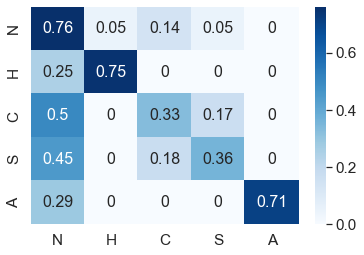

In [197]:
best_model = 'XGB'
X_train, X_test, Y_train, Y_test = train_test_split(data_fixed_filter, label_fixed, test_size=0.2)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = classifiers[classifiers_name.index(best_model)]
model.fit(X_train, Y_train)

performance_metrics = compute_metrics(model, X_test, Y_test, show=True)
plot_confusion_matrix(performance_metrics["Confusion Matrix"])

### Binary classification

In [69]:
## binary classification with XGBoost
for emotion_index in range(5):
    f1_micro = np.array([])
    f1_macro = np.array([])
    recall = np.array([])
    
    print("Class " + label_dictionary[emotion_index+1] + ":")
    label_fixed_binary = (label_fixed == emotion_index).astype(int)
    
    for i in range(10):
        model = xgb.XGBClassifier(objective='binary:logistic',eval_metric='mlogloss',use_label_encoder=False)
        scores = model_selection.cross_validate(model, X=data_fixed_filter, y=label_fixed_binary, cv=10, n_jobs=1, scoring=['f1_micro','f1_macro','recall'])
        
        f1_micro = np.concatenate([f1_micro, scores['test_f1_micro']])
        f1_macro = np.concatenate([f1_macro, scores['test_f1_macro']])
        recall = np.concatenate([recall, scores['test_recall']])
        
    print(np.round(np.nanmean(f1_micro),3), np.round(np.nanstd(f1_micro),3))
    print(np.round(np.nanmean(f1_macro),3), np.round(np.nanstd(f1_macro),3))
    print(np.round(np.nanmean(recall),3), np.round(np.nanstd(recall),3))
    
    print()
    print()

Class N:
0.658 0.12
0.655 0.121
0.6 0.128


Class H:
0.844 0.056
0.644 0.1
0.342 0.173


Class C:
0.86 0.042
0.507 0.096
0.067 0.133


Class S:
0.844 0.059
0.566 0.126
0.167 0.167


Class A:
0.893 0.019
0.516 0.091
0.083 0.171




In [68]:
## binary classification with Random Forest
for emotion_index in range(5):
    f1_micro = np.array([])
    f1_macro = np.array([])
    recall = np.array([])
    
    print("Class " + label_dictionary[emotion_index+1] + ":")
    label_fixed_binary = (label_fixed == emotion_index).astype(int)
    
    for i in range(10):
        model = RandomForestClassifier(n_estimators=200, max_depth=5, class_weight={0:0.1,1:1})
        scores = model_selection.cross_validate(model, X=data_fixed_filter, y=label_fixed_binary, cv=10, n_jobs=1, scoring=['f1_micro','f1_macro','recall'])
        
        f1_micro = np.concatenate([f1_micro, scores['test_f1_micro']])
        f1_macro = np.concatenate([f1_macro, scores['test_f1_macro']])
        recall = np.concatenate([recall, scores['test_recall']])
        
    print(np.round(np.nanmean(f1_micro),3), np.round(np.nanstd(f1_micro),3))
    print(np.round(np.nanmean(f1_macro),3), np.round(np.nanstd(f1_macro),3))
    print(np.round(np.nanmean(recall),3), np.round(np.nanstd(recall),3))
    
    print()
    print()

Class N:
0.579 0.077
0.498 0.122
0.961 0.055


Class H:
0.845 0.06
0.605 0.137
0.249 0.215


Class C:
0.819 0.065
0.549 0.112
0.243 0.262


Class S:
0.803 0.125
0.622 0.14
0.384 0.215


Class A:
0.891 0.029
0.567 0.135
0.223 0.332




In [96]:
## binary classification with SVM
for emotion_index in range(5):
    f1_micro = np.array([])
    f1_macro = np.array([])
    recall = np.array([])
    
    print("Class " + label_dictionary[emotion_index+1] + ":")
    label_fixed_binary = (label_fixed == emotion_index).astype(int)
    
    for i in range(10):
        model = SVC(kernel='rbf',decision_function_shape='ovr', probability=True)
        scores = model_selection.cross_validate(model, X=data_fixed_filter, y=label_fixed_binary, cv=10, n_jobs=1, scoring=['f1_micro','f1_macro','recall'])
        
        f1_micro = np.concatenate([f1_micro, scores['test_f1_micro']])
        f1_macro = np.concatenate([f1_macro, scores['test_f1_macro']])
        recall = np.concatenate([recall, scores['test_recall']])
        
    print(np.round(np.nanmean(f1_micro),3), np.round(np.nanstd(f1_micro),3))
    print(np.round(np.nanmean(f1_macro),3), np.round(np.nanstd(f1_macro),3))
    print(np.round(np.nanmean(recall),3), np.round(np.nanstd(recall),3))
    
    print()
    print()

Class N:
0.669 0.112
0.648 0.128
0.542 0.259


Class H:
0.852 0.019
0.46 0.006
0.0 0.0


Class C:
0.872 0.011
0.466 0.003
0.0 0.0


Class S:
0.868 0.014
0.465 0.004
0.0 0.0


Class A:
0.902 0.019
0.474 0.005
0.0 0.0




## Feature importance

In [28]:
# data standardization
scaler = MinMaxScaler()
data_fixed = pd.DataFrame(scaler.fit_transform(data_fixed), columns=data_fixed.columns)

#### Chi-squared

In [29]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

demo_features = np.array(['typeWith','gender','ageRange','degree','pcTimeAverage','status','country','typistType'])

# Feature extraction
test = SelectKBest(score_func=chi2, k=8)
fit = test.fit(data_fixed.loc[:,demo_features].fillna(100).replace(-1,16), pd.cut(data_fixed.D1U2_mean.fillna(0),bins=[0,372,445,573,4306],labels=[1,2,3,4]).fillna(1))

# Summarize scores
np.set_printoptions(precision=3)
print("Ordered features by importance with their corresponding chi2 score")
print(demo_features[np.argsort(fit.scores_)][::-1])
print(fit.scores_[np.argsort(fit.scores_)][::-1])

Ordered features by importance with their corresponding chi2 score
['country' 'pcTimeAverage' 'status' 'typistType' 'degree' 'typeWith'
 'gender' 'ageRange']
[18.781  6.822  5.795  3.739  1.871  1.854  1.506  1.474]


#### Correlation coefficients

In [30]:
importances = data_fixed.apply(lambda x: x.corr(data_fixed.D1U2_mean))
indices = np.argsort(importances)
indices_abs = np.argsort(np.abs(importances))[::-1]
print(importances[indices_abs])

D1U2_mean        1.000000
U1D2_mean        0.972890
U1U2_mean        0.915055
D1D2_mean        0.911282
D1U2_std         0.790524
U1D2_std         0.783093
U1U2_std         0.749809
D1D2_std         0.740526
editDistance     0.455710
nbKeystroke      0.427721
TotTime          0.301473
typistType       0.149490
D1U1_std         0.125646
D1U1_mean        0.113105
status          -0.100291
answer          -0.092404
pcTimeAverage   -0.086800
country          0.081245
gender          -0.060056
degree          -0.014117
delFreq          0.011358
leftFreq        -0.011001
typeWith        -0.003644
ageRange         0.000889
dtype: float64


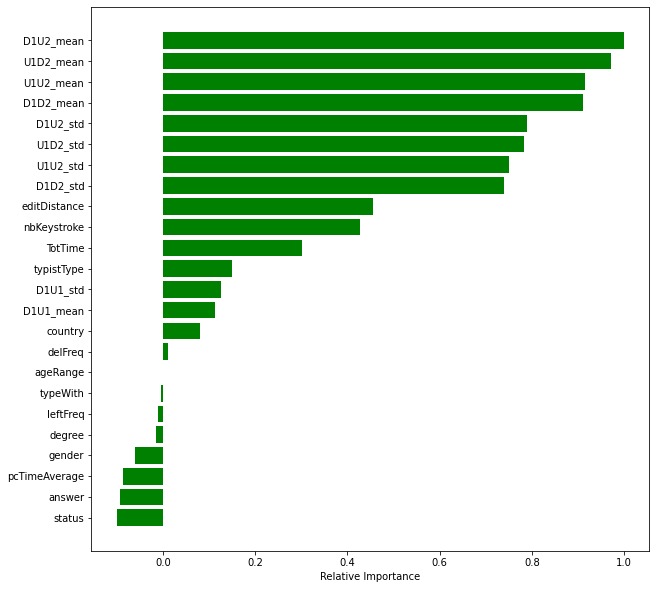

In [31]:
plt.figure(figsize=(10,10))
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), importances[indices].index.values)
plt.xlabel('Relative Importance')
plt.show()

#### Information Gain

In [32]:
from info_gain import info_gain 

importances_ig = []
for col in data_fixed.columns:
    importances_ig.append(info_gain.info_gain(data_fixed[col],data_fixed.D1U2_mean))
indices_ig = np.argsort(importances_ig)[::-1]
pd.concat([pd.Series(data_fixed.columns[indices_ig]), pd.Series(np.sort(importances_ig)[::-1])], axis=1).set_index(0)

,1
0,
D1D2_mean,5.493061
D1U2_std,5.493061
U1D2_mean,5.493061
U1D2_std,5.493061
U1U2_mean,5.493061
U1U2_std,5.493061
D1U2_mean,5.493061
D1U1_std,5.493061
D1U1_mean,5.493061


#### Mutual information

<AxesSubplot:>

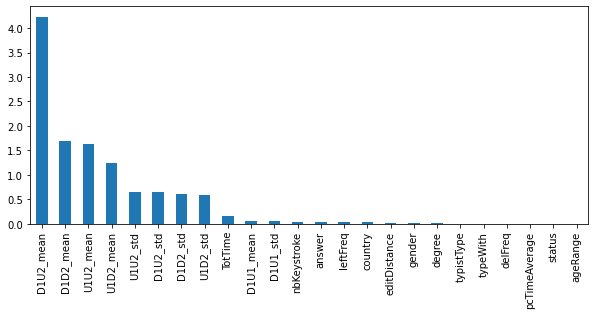

In [33]:
from sklearn.feature_selection import mutual_info_regression

mi = mutual_info_regression(data_fixed, data_fixed.D1U2_mean)
mi = pd.Series(mi)
mi.index = data_fixed.columns
mi.sort_values(ascending=False)
mi.sort_values(ascending=False).plot.bar(figsize=(10, 4))

#### Recursive Feature Elimination (RFE)

In [36]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000) 
rfe = RFE(model, 1)
fit = rfe.fit(data_fixed, label_fixed)
 
print("Feature Ranking: %s"% fit.ranking_)

Feature Ranking: [14 20 15 16 17 11 24 13 19 18 12  5  6 10  2  8  9 21  7 22  4  3  1 23]


In [37]:
list(data_fixed.columns[fit.ranking_ - 1])

['country',
 'nbKeystroke',
 'degree',
 'delFreq',
 'editDistance',
 'U1U2_std',
 'typistType',
 'answer',
 'leftFreq',
 'gender',
 'ageRange',
 'D1U2_mean',
 'D1U2_std',
 'U1U2_mean',
 'D1D2_std',
 'U1D2_mean',
 'U1D2_std',
 'pcTimeAverage',
 'TotTime',
 'status',
 'D1U1_std',
 'D1U1_mean',
 'D1D2_mean',
 'typeWith']

#### SHAP values

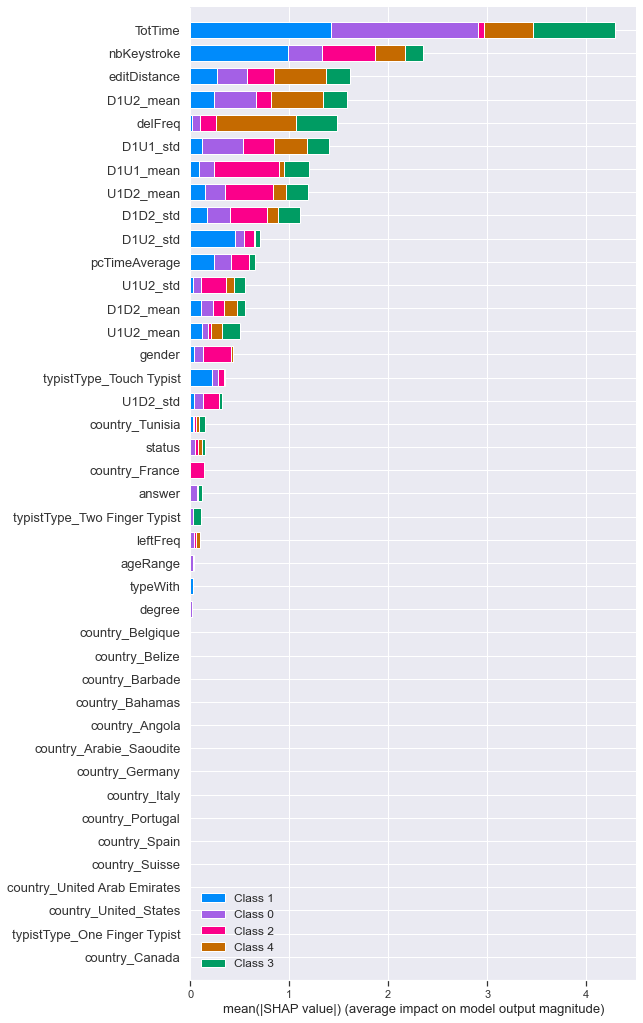

In [123]:
# DF, based on which importance is checked
X_importance = pd.DataFrame(data_fixed, columns=data_fixed.columns)

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)

# Plot summary_plot
shap.summary_plot(shap_values, X_importance, max_display=len(data_fixed.columns))

#### RF feature importance

Metric : ACC, Score :  0.80
Metric : TP_Rate, Score :  0.61
Metric : FP_Rate, Score :  0.13
Metric : Precision, Score :  0.50
Metric : F_Measure, Score :  0.55
Metric : F_Micro, Score :  0.49
Metric : F_Macro, Score :  0.50
Confusion Matrix: 
      N     H     C     S     A
N  0.32  0.11  0.50  0.86  1.33
H  0.05  0.78  0.12  0.00  0.00
C  0.05  0.00  0.38  0.43  0.33
S  0.05  0.11  0.12  0.57  0.00
A  0.00  0.00  0.00  0.00  1.00
here 2


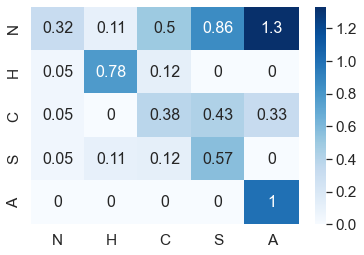

In [126]:
best_model = 'RF'
X_train, X_test, Y_train, Y_test = train_test_split(data_fixed, label_fixed, test_size=0.2)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = classifiers[classifiers_name.index(best_model)]
model.fit(X_train, Y_train)

performance_metrics = compute_metrics(model, X_test, Y_test, show=True)
plot_confusion_matrix(performance_metrics["Confusion Matrix"])

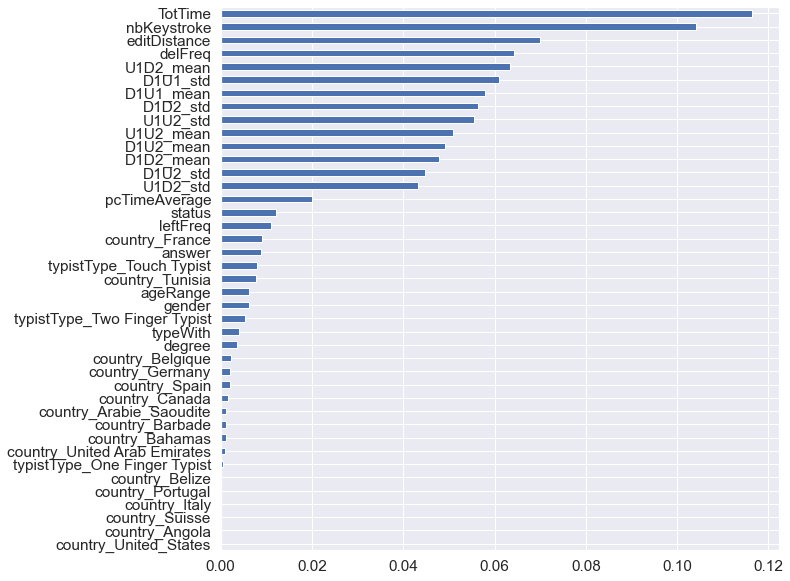

In [127]:
plt.figure(figsize=(10,10))
pd.Series(model.feature_importances_, index=data_fixed.columns).nlargest(data_fixed.shape[1])[::-1].plot(kind='barh')
plt.show()

#### XGB feature importance

Metric : ACC, Score :  0.80
Metric : TP_Rate, Score :  0.42
Metric : FP_Rate, Score :  0.15
Metric : Precision, Score :  0.47
Metric : F_Measure, Score :  0.44
Metric : F_Micro, Score :  0.49
Metric : F_Macro, Score :  0.43
Confusion Matrix: 
      N     H     C     S     A
N  0.70  0.12  0.33  0.22  0.00
H  0.20  0.50  0.00  0.00  0.00
C  0.20  0.00  0.22  0.22  0.33
S  0.25  0.00  0.00  0.33  0.33
A  0.05  0.12  0.00  0.00  0.33
here 2


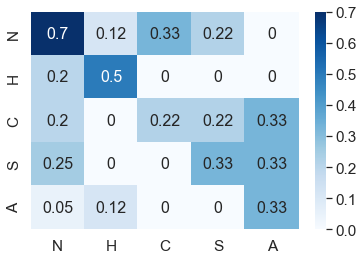

In [125]:
best_model = 'XGB'
X_train, X_test, Y_train, Y_test = train_test_split(data_fixed, label_fixed, test_size=0.2)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = classifiers[classifiers_name.index(best_model)]
model.fit(X_train, Y_train)

performance_metrics = compute_metrics(model, X_test, Y_test, show=True)
plot_confusion_matrix(performance_metrics["Confusion Matrix"])

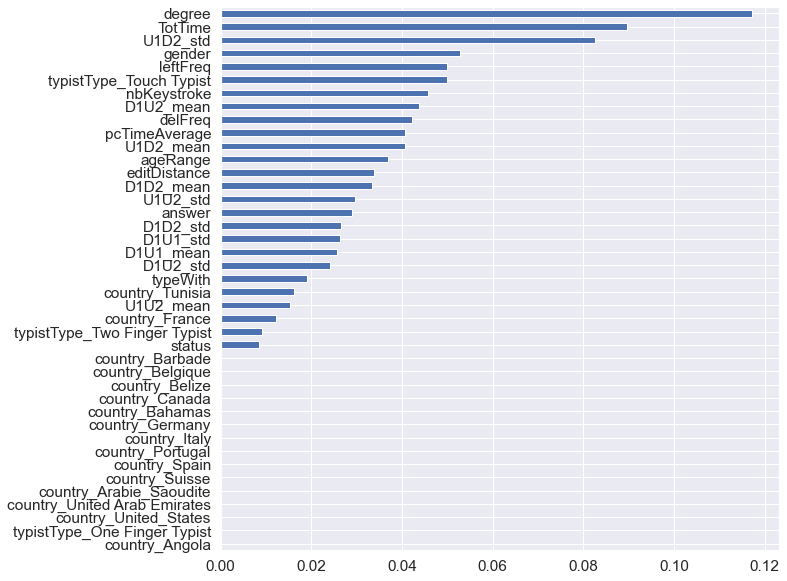

In [124]:
plt.figure(figsize=(10,10))
pd.Series(model.feature_importances_, index=data_fixed.columns).nlargest(data_fixed.shape[1])[::-1].plot(kind='barh')
plt.show()